In [1]:
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib.patches import Rectangle
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm

In [2]:
nc = Dataset("./DATA/BOLAVEN/VOgeo_NCL.nc", "r") # 2012-08-26 00 UTC 25.3N 129.5E

gvort = nc.variables["VOgeo"][:, :] # lat, lon
lats  = nc.variables["lat"][:]
lons  = nc.variables["lon"][:]

In [35]:
leftDomain, rightDomain =  75., 175.
downDomain,    upDomain = -10.,  60.

latsIdx = np.where((lats >= downDomain) & (lats <=    upDomain))[0]
lonsIdx = np.where((lons >= leftDomain) & (lons <= rightDomain))[0]

gvortDomain = gvort[latsIdx][:, lonsIdx]
latsDomain  = lats[latsIdx]
lonsDomain  = lons[lonsIdx]

xx, yy = np.meshgrid(lonsDomain, latsDomain)

In [36]:
ncGeo = Dataset("./DATA/BOLAVEN/ght.20120826.500.nc", "r")

geo = ncGeo.variables["z"][0, :: -1, :]
geoDomain = geo[latsIdx][:, lonsIdx]

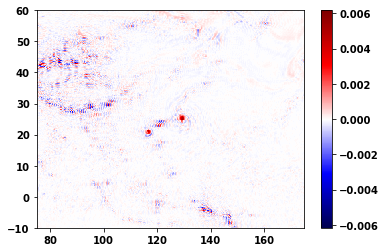

In [37]:
absMax = np.nanmax(np.abs(gvortDomain))

plot = plt.pcolor(xx, yy, gvortDomain, cmap = "seismic", vmin = -absMax, vmax = absMax)
plt.colorbar(plot)

Threshold Vorticity: -2.837414e-05


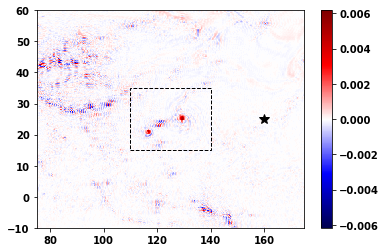

In [39]:
latThre, lonThre =  25. , 160.
lllat  , urlat   =  15. ,  35.
lllon  , urlon   = 110. , 140.

threshold = gvortDomain[np.where(latsDomain == latThre)[0][0], np.where(lonsDomain == lonThre)[0][0]]
print("Threshold Vorticity: %e" % threshold)

fig, sub = plt.subplots()

plot = sub.pcolor(xx, yy, gvortDomain, cmap = "seismic", vmin = -absMax, vmax = absMax)
sub.plot(lonThre, latThre, marker = "*", c = "k", ms = 10)
sub.add_patch(Rectangle((lllon, lllat), urlon - lllon, urlat - lllat, fill = None, ls = "--"))

fig.colorbar(plot)

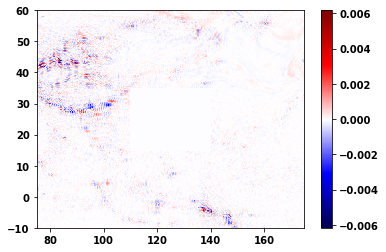

In [40]:
typhoonWO = np.full(gvortDomain.shape, np.nan, dtype = float)

for j, lat in enumerate(latsDomain):
    for i, lon in enumerate(lonsDomain):
        if (lat >= lllat) & (lat <= urlat) & (lon >= lllon) & (lon <= urlon):
            if (gvortDomain[j, i] != threshold):
                typhoonWO[j, i] = threshold
            else:
                typhoonWO[j, i] = gvortDomain[i, j]
        else:
            typhoonWO[j, i] = gvortDomain[j, i]
            
plot = plt.pcolor(xx, yy, typhoonWO, cmap = "seismic", vmin = -absMax, vmax = absMax)

plt.colorbar(plot)

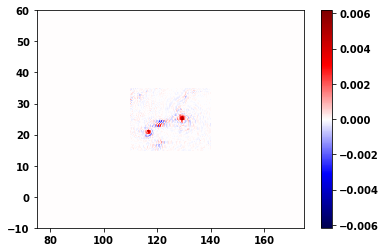

In [41]:
typhoonW = gvortDomain - typhoonWO

plot = plt.pcolor(xx, yy, typhoonW, cmap = "seismic", vmin = -absMax, vmax = absMax)

plt.colorbar(plot)

In [42]:
def dist(lon1, lat1, lon2, lat2):
    lon1 = radians(lon1)
    lat1 = radians(lat1)
    lon2 = radians(lon2)
    lat2 = radians(lat2)
    
    dlon = np.abs(lon2 - lon1)
    dlat = np.abs(lat2 - lat1)
    
    a = sin(dlat / 2.) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2.) ** 2
    c = 2. * atan2(sqrt(a), sqrt(1. - a))
    
    return 6373000. * c

In [50]:
def Poisson(method, vort, latList, lonList, maxIter, lmIter, background, weight = 0.8):
    oldRsd = 1000000.
    
    dlon = np.abs(lonList[1] - lonList[0])
    dlat = np.abs(latList[1] - latList[0])
    
    w  = (2. * np.pi) / (24. * 60. * 60.)
    
    if background == "typhoon":
        grids = np.zeros(vort.shape, dtype = float)
    elif background == "notyphoon":
        grids = geoDomain
    
    for n in tqdm(range(maxIter), total = maxIter, desc = method.upper()):
        if n == 0:
            gridsOld = cp.deepcopy(grids)
            gridsNew = cp.deepcopy(grids)
        
        for i, lon in enumerate(lonList[1 : -1]):
            i += 1
            for j, lat in enumerate(latList[1 : -1]):
                j += 1
                
                dx = dist(lon, lat, lon + dlon, lat       )
                dy = dist(lon, lat, lon       , lat + dlat)
                c  = dx / dy
                e  = (2. * (1. + (c ** 2))) ** (-1)
                f0 = 2. * w * sin(radians(lat))
                
                a1 = gridsOld[j, i + 1] + gridsOld[j, i - 1]
                a2 = (c ** 2) * (gridsOld[j + 1, i] + gridsOld[j - 1, i])
                a3 = c * dx * dy * f0 * vort[j, i]
                
                if method == "jacobi":
                    gridsNew[j, i] = e * (a1 + a2 - a3)
                
                elif method == "sor":
                    gridsNew[j, i] = gridsOld[j, i] * (1. - weight) + weight * e * (a1 + a2 - a3)
                
        newRsd = np.sqrt(np.nanmean((gridsNew - gridsOld) ** 2))
        check  = np.abs(newRsd - oldRsd) / oldRsd
        
        gridsOld = cp.deepcopy(gridsNew)
        oldRsd   = cp.deepcopy(newRsd)
        
        if check < lmIter:
            print("Early stopped!")
            print("Iteration: %i, Check: %f" % (n, check))
            break
        
        elif n == nIter - 1:
            print("Iteration: %i, Check: %f" % (n, check))
            pass
        
        else:
            continue
        
    return gridsNew

In [54]:
nIter  = 1000
lmIter = 0.0001

typhoonWGeo  = Poisson("jacobi", typhoonW , latsDomain, lonsDomain, nIter, lmIter, "typhoon")
typhoonWOGeo = Poisson("jacobi", typhoonWO, latsDomain, lonsDomain, nIter, lmIter, "notyphoon")

JACOBI:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration: 999, Check: 0.000338


JACOBI: 100%|██████████| 1000/1000 [37:34<00:00,  2.25s/it]

Iteration: 999, Check: 0.000420


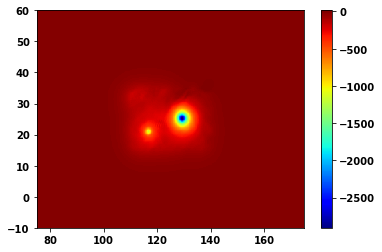

In [55]:
plot = plt.pcolor(xx, yy, typhoonWGeo, cmap = "jet")

plt.colorbar(plot)

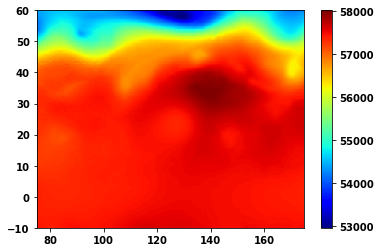

In [56]:
plot = plt.pcolor(xx, yy, typhoonWOGeo, cmap = "jet")

plt.colorbar(plot)

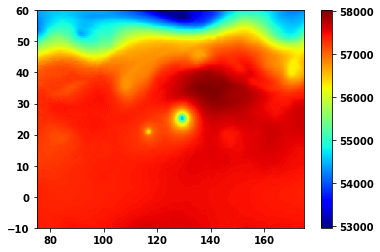

In [57]:
plot = plt.pcolor(xx, yy, typhoonWOGeo + typhoonWGeo, cmap = "jet")

plt.colorbar(plot)

56979.871421443044


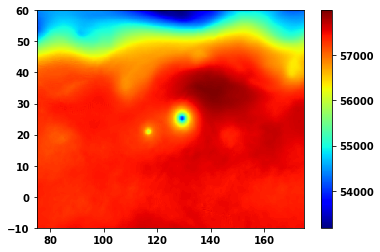

In [58]:
plot = plt.pcolor(xx, yy, geoDomain, cmap = "jet")
plt.colorbar(plot)

print(np.nanmean(geoDomain))

In [59]:
typhoonWGeo  = Poisson("sor", typhoonW , latsDomain, lonsDomain, nIter, lmIter, "typhoon")
typhoonWOGeo = Poisson("sor", typhoonWO, latsDomain, lonsDomain, nIter, lmIter, "notyphoon")

SOR:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration: 999, Check: 0.000349


SOR: 100%|██████████| 1000/1000 [41:16<00:00,  2.48s/it]

Iteration: 999, Check: 0.000436


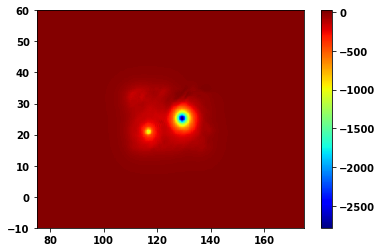

In [60]:
plot = plt.pcolor(xx, yy, typhoonWGeo, cmap = "jet")

plt.colorbar(plot)

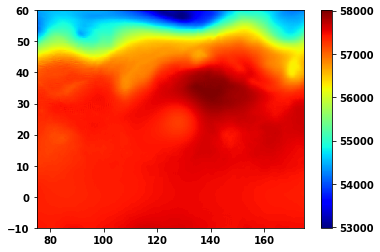

In [61]:
plot = plt.pcolor(xx, yy, typhoonWOGeo, cmap = "jet")

plt.colorbar(plot)

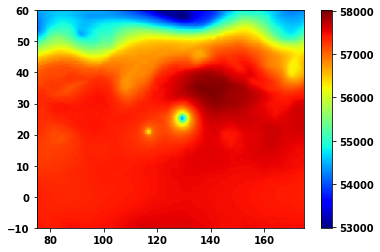

In [62]:
plot = plt.pcolor(xx, yy, typhoonWOGeo + typhoonWGeo, cmap = "jet")

plt.colorbar(plot)